In [10]:
using LinearAlgebra
using Unitful
using UnitfulAstro
using OrdinaryDiffEq
using Plots
using CoordinateTransformations
#using FLoops
#using Distributed
#using DisplayAs
#include("./GalaxyCollisionFunctions.jl")
#addprocs(4)
theme(:dracula)

In [130]:
const G = 4.3009E-3 *1u"pc *(km/s)^2 /Msun"

function Spherical2Polar(r,ϕ,θ)
    x = r * cos(ϕ)* sin(θ)
    y = r*sin(ϕ)*sin(θ)
    z = r*cos(θ)
return [x,y,z]
end
function format_parameters(galaxy_args)
    #I didn't have this at first, but this makes all galaxies have an uniform format. Not too crazy
    return Dict(
        "mass" => galaxy_args[1]*1u"Msun",
        "DiskRadius"     => galaxy_args[2]*1u"kpc",
        "BulgeRadius" => galaxy_args[3]*1u"pc",
        "center_pos" => galaxy_args[4].*1u"kpc",
        "center_vel" => galaxy_args[5].*1u"km/s",
        "normal"     => galaxy_args[6],
        "NₛDisk"    => galaxy_args[7],
        "NₛBulge"    => galaxy_args[8],
        "softening"  => galaxy_args[9]
    )
end
function init_disk!(galaxy,dT=1E-4u"Myr")
    #=
    This function takes a 'galaxy' as an argument, which is an array of 8 arguments=>
        [mass,DiskRadius,center_pos,center_vel,normal,N_rings,N_stars,softening]
    And outputs the star positions, velocities and the velocity scale.
    =#
#-------------------------------------------------------------Rotations--------------------------------------------------------------
    if norm(galaxy["normal"]) == 0 
        Rotation = I
    else 
        cosθ = normalize(galaxy["normal"])[3]
        sinθ = √(1-cosθ^2)
        u = [0,0,1] × normalize(galaxy["normal"])
        if norm(u) == 0 
            Rotation = I
        else 
         u = normalize(u)

        Rotation = [
            u[1]*u[1]*(1-cosθ)+cosθ u[1]*u[2]*(1-cosθ)-u[2]*sinθ u[1]*u[3]*(1-cosθ)+u[1]*sinθ;

            u[2]*u[1]*(1-cosθ)+u[3]*sinθ u[2]*u[2]*(1-cosθ)+cosθ u[2]*u[3]*(1-cosθ)-u[1]*sinθ;

            u[3]*u[1]*(1-cosθ)+u[2]*sinθ u[3]*u[1]*(1-cosθ)+u[1]*sinθ u[3]*u[3]*(1-cosθ)+cosθ
            ]
        end
    end
#-----------------------------------------------------------------------------------------------------------------------------------
    galaxy["star_pos"] = []
    galaxy["star_vel"] = []
#----------------------------------------------------------------------Making the Disk--------------------------------------------------------------------------------------------
    Rminimum = galaxy["softening"] * galaxy["DiskRadius"]
    Rdisk = (-log.(rand(galaxy["NₛDisk"]))*galaxy["DiskRadius"] .+Rminimum)*1u"1/kpc" #This (by inverse tansform sampling) gives us a negative exponential distribution on the masses. Basing myself on https://arxiv.org/pdf/1608.08350.pdf for this model
    ϕdisk = 2π *rand(galaxy["NₛDisk"])
    # Positions 
    vecᵣ = (Rotation * ([Rdisk.*cos.(ϕdisk),Rdisk.*sin.(ϕdisk),zeros(galaxy["NₛDisk"])])).*1u"kpc"
    x = ustrip.(u"m",galaxy["center_pos"][1].+vecᵣ[1])#here, we strip our units into our 'integrating' unitlessness because units don't really play nice in arrays of arrays
    y = ustrip.(u"m",galaxy["center_pos"][2].+vecᵣ[2])
    z = ustrip.(u"m",galaxy["center_pos"][3].+vecᵣ[3])

    # Velocities
    Tₛ = 2π * uconvert.(u"s",sqrt.((Rdisk*1u"kpc").^3/(G *galaxy["mass"])))

    Δϕ = 2π *uconvert(u"s",dT)./Tₛ 

    vecᵥ = (Rotation* [(Rdisk/(uconvert(u"s",dT)*1u"1/s")).*(cos.(ϕdisk)-cos.(ϕdisk-Δϕ)),Rdisk/(uconvert(u"s",dT)*1u"1/s").*(sin.(ϕdisk)-sin.(ϕdisk-Δϕ)),zeros(galaxy["NₛDisk"])])*1u"kpc/s"
    v₁ = ustrip.(u"m/s",galaxy["center_vel"][1].+vecᵥ[1])
    v₂ = ustrip.(u"m/s",galaxy["center_vel"][2].+vecᵥ[2])
    v₃ = ustrip.(u"m/s",galaxy["center_vel"][3].+vecᵥ[3])
    for j ∈ 1:galaxy["NₛDisk"]
        push!(galaxy["star_pos"],[x[j],y[j],z[j]])
        push!(galaxy["star_vel"],[v₁[j],v₂[j],v₃[j]])
    end
#---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Rminimum = galaxy["softening"] * galaxy["BulgeRadius"]
    Rbulge = (-log.(rand(galaxy["NₛBulge"]))*galaxy["BulgeRadius"] .+Rminimum) #This (by inverse tansform sampling) gives us a negative exponential distribution on the masses. Basing myself on https://arxiv.org/pdf/1608.08350.pdf for this model
    ϕbulge = 2π *rand(galaxy["NₛBulge"])
    θbulge = π *rand(galaxy["NₛBulge"])
    vecᵣbulge = Spherical2Polar.(ustrip.(u"m",Rbulge),ϕbulge,θbulge)
    shenanigate = reduce(vcat,transpose(vecᵣbulge))
    Xbulge = ustrip(u"m",galaxy["center_pos"][1]).+shenanigate[:,1]
    Ybulge = ustrip(u"m",galaxy["center_pos"][2]).+shenanigate[:,2]
    Zbulge = ustrip(u"m",galaxy["center_pos"][3]).+shenanigate[:,3]
    Vbulge = []
    vecᵣbulge[:,1]
    for j ∈ 1:galaxy["NₛBulge"]
        push!(Vbulge,ustrip.(u"m/s",√(G *galaxy["mass"]/Rbulge[j])) *normalize(vecᵣbulge[j] × rand(3)))
    end
    shenanigatevel = reduce(vcat,transpose(Vbulge))
    v₁bulge = ustrip(u"m/s",galaxy["center_vel"][1]).+shenanigatevel[:,1]
    v₂bulge = ustrip(u"m/s",galaxy["center_vel"][2]).+shenanigatevel[:,2]
    v₃bulge = ustrip(u"m/s",galaxy["center_vel"][3]).+shenanigatevel[:,3]
    for j ∈ 1:galaxy["NₛBulge"]
        push!(galaxy["star_pos"],[Xbulge[j],Ybulge[j],Zbulge[j]])
        push!(galaxy["star_vel"],[v₁bulge[j],v₂bulge[j],v₃bulge[j]])
    end
#----------------------------------------------------------------------------Making Bulge-----------------------------------------------------------------------------------------



end

function evolve_disk(galaxy,dT=1e-4u"yr",N_steps=100000,frames=500)
    divs = trunc(Int64,N_steps/frames)
    #Integration stuff
    dT=ustrip(u"s",dT)
    rₘ=ustrip(u"m",galaxy["softening"]*galaxy["DiskRadius"])
    @show Nₛ=galaxy["NₛDisk"]+galaxy["NₛDisk"]
    
    #Galaxy stuff
    M = ustrip(u"Msun",galaxy["mass"])
    R₀ = ustrip.(u"m",galaxy["center_pos"])
    V₀ = ustrip.(u"m/s",galaxy["center_vel"])

    #star stuff
    rₛ=galaxy["star_pos"]
    vₛ=galaxy["star_vel"]

    function Gravity(dq::Vector{Float64},q::Vector{Float64},m,t::Float64)::Vector{Float64}
        r = q[1:3]
        R = q[4:6]
        ddr = ustrip(u"m^3/s^2",G*M*1u"Msun")*(R-r)/max(norm(R-r),rₘ)^3
        ddR = [0,0,0]
        append!(ddr,ddR)
        return ddr
    end
    Integrator=[]
    for i ∈ 1:Nₛ
        append!(vₛ[i],V₀)
        append!(rₛ[i],R₀)
    end
    for i ∈ 1:Nₛ
        push!(Integrator,init(SecondOrderODEProblem(Gravity,vₛ[i],rₛ[i],(0,dT*N_steps)),dt=dT,SymplecticEuler()))
    end 
    snapshot = zeros(frames,Nₛ+1,3)
    time = zeros(frames)
        for i ∈ 1:frames
            for j ∈ 1:Nₛ
                snapshot[i,j,:] =Integrator[j].u[7:9]*3.240779289444365e-20
            end
            snapshot[i,Nₛ+1,:] = Integrator[1].u[10:12]*3.240779289444365e-20
            time[i]=Integrator[1].t

            for j ∈ 1:divs
                step!.(Integrator)
            end
        end
    return snapshot,time 
end

function gif_galaxy(data,time,Nₛ,xlimit=[0,0],ylimit=[0,0],zlimit=[0,0])
    if ((norm(xlimit) == 0.0) || (norm(ylimit) == 0.0) || (norm(zlimit) == 0.0))
        xlimit = [minimum(data[:,:,1]),maximum(data[:,:,1])]
        ylimit = [minimum(data[:,:,2]),maximum(data[:,:,2])]
        zlimit = [minimum(data[:,:,3]),maximum(data[:,:,3])]
    end
    @gif for i ∈ 1:length(time)
        scatter3d(xlim=xlimit,ylim=ylimit,zlim=zlimit)
        for j ∈ 1:Nₛ
            scatter3d!(data[i:i,j,1],data[i:i,j,2],data[i:i,j,3], color=:red,legends=false,markersize=1.5)
           # i > trail ? plot3d!(Rotated[j][1,1:i],Rotated[j][2,1:i],Rotated[j][3,1:i]) : nothing
        end
        scatter3d!(data[i:i,Nₛ+1,1],data[i:i,Nₛ+1,2],data[i:i,Nₛ+1,3], color=:black,legends=false)
    end 
end

function gif_two_galaxies(data,time,N₁,N₂,xlimit=[0,0],ylimit=[0,0],zlimit=[0,0])
    if ((norm(xlimit) == 0.0) || (norm(ylimit) == 0.0) || (norm(zlimit) == 0.0))
        xlimit = [minimum(data[1:5,:,1]),maximum(data[1:5,:,1])]
        ylimit = [minimum(data[1:5,:,2]),maximum(data[1:5,:,2])]
        zlimit = [minimum(data[1:5,:,3]),maximum(data[1:40,:,3])]
    end
    @gif for i ∈ 1:length(time)
        scatter3d(xlim=xlimit,ylim=ylimit,zlim=zlimit)
        for j ∈ 1:N₁
            scatter3d!(data[i:i,j,1],data[i:i,j,2],data[i:i,j,3], color=:red,legends=false,markersize=1)
        end
        for j ∈ 1:N₂
            scatter3d!(data[i:i,N₁+j,1],data[i:i,N₁+j,2],data[i:i,N₁+j,3], color=:blue,legends=false,markersize=1)
           # i > trail ? plot3d!(Rotated[j][1,1:i],Rotated[j][2,1:i],Rotated[j][3,1:i]) : nothing
        end
        scatter3d!(data[i:i,N₁+N₂+1,1],data[i:i,N₁+N₂+1,2],data[i:i,N₁+N₂+1,3], color=:black,legends=false)
        scatter3d!(data[i:i,N₁+N₂+2,1],data[i:i,N₁+N₂+2,2],data[i:i,N₁+N₂+2,3], color=:black,legends=false)
    end 
end

function evolve_two_disks(primary,secondary,dT=1e-4u"yr",N_steps=100000,frames=500)
    #Integration stuff
    divs = trunc(Int64,N_steps/frames)
    dT=ustrip(u"s",dT)
    r₁ₘ,r₂ₘ=ustrip(u"m",primary["softening"]*primary["DiskRadius"]),ustrip(u"m",secondary["softening"]*secondary["DiskRadius"])
    N₁ₛ,N₂ₛ=primary["Nₛ"],secondary["Nₛ"]
    
    #Galaxy stuff
    M = [ustrip(u"Msun",primary["mass"]),ustrip(u"Msun",secondary["mass"])]
    R₁,R₂ = ustrip.(u"m",primary["center_pos"]),ustrip.(u"m",secondary["center_pos"])
    V₁,V₂ = ustrip.(u"m/s",primary["center_vel"]),ustrip.(u"m/s",secondary["center_vel"])

    #star stuff
    r₁,r₂=primary["star_pos"],secondary["star_pos"]
    v₁,v₂=primary["star_vel"], secondary["star_vel"]


    function Gravitus(dq::Vector{Float64},q::Vector{Float64},m::Vector{Float64},t::Float64)::Vector{Float64}
        pegnor= q[1:3]
        R₁,R₂= q[4:6],q[7:9]
        ddpegnor = ustrip(u"m^3/s^2",G*m[1]*1u"Msun")*(R₁-pegnor)/max(norm(R₁-pegnor),r₁ₘ)^3+ustrip(u"m^3/s^2",G*m[2]*1u"Msun")*(R₂-pegnor)/max(norm(R₂-pegnor),r₂ₘ)^3
        ddR₁ = ustrip(u"m^3/s^2",G*m[1]*1u"Msun")*(R₂-R₁)/max(norm(R₁-R₂),r₁ₘ)^3
        ddR₂ = -ddR₁
        append!(ddpegnor,ddR₁,ddR₂)
        return ddpegnor
    end
    
    Integrator=[]
    for i ∈ 1:N₁ₛ
        append!(v₁[i],V₁,V₂)
        append!(r₁[i],R₁,R₂)
    end
    for i ∈ 1:N₂ₛ
        append!(v₂[i],V₁,V₂)
        append!(r₂[i],R₁,R₂)
    end
    
    for k ∈ 1:N₁ₛ
        push!(Integrator,init(SecondOrderODEProblem(Gravitus,v₁[k],r₁[k],(0,N_steps*dT),M),dt=dT,SymplecticEuler()))
    end
    
    for i ∈ 1:N₂ₛ
        push!(Integrator,init(SecondOrderODEProblem(Gravitus,v₂[i],r₂[i],(0,N_steps*dT),M),dt=dT,SymplecticEuler()))
    end 
    snapshot = zeros(frames,N₁ₛ+N₂ₛ+2,3)
    time = zeros(frames)
        for i ∈ 1:frames
            for j ∈ 1:N₁ₛ
                snapshot[i,j,:] =Integrator[j].u[10:12]*3.240779289444365e-20
            end
            for j ∈ 1:N₂ₛ
                snapshot[i,N₁ₛ+j,:] =Integrator[N₁ₛ+j].u[10:12]*3.240779289444365e-20
            end
            snapshot[i,N₁ₛ+N₂ₛ+1,:] = Integrator[1].u[13:15]*3.240779289444365e-20
            snapshot[i,N₁ₛ+N₂ₛ+2,:] = Integrator[1].u[16:18]*3.240779289444365e-20
            time[i]=Integrator[1].t * ustrip(u"Myr",1u"s")
            for j ∈ 1:divs
                step!.(Integrator)
            end
        end
    return snapshot,time 
end


evolve_two_disks (generic function with 4 methods)

In [132]:
Target = format_parameters([5e10, 5,1, [-5,5,1], [15,-15,0], [0,0,0],1000,800, 0.025])
#Introoder = format_parameters([1e10,5,[25,-25,-5],[-75,75,0],[0,0,1],5,200,0.025])
#init_disk!(Introoder)
init_disk!(Target)
#data, time = evolve_two_disks(Introoder,Target,0.5u"Myr",1000,200){}
data,time = evolve_disk(Target,0.05u"Myr",10000,300)

BoundsError: BoundsError: attempt to access 1800-element Vector{Any} at index [1801]

┌ Info: Saved animation to C:\Users\batti\AppData\Local\Temp\jl_aVyt4fs52z.gif
└ @ Plots C:\Users\batti\.julia\packages\Plots\QZRtR\src\animation.jl:156


Plots.AnimatedGif("C:\\Users\\batti\\AppData\\Local\\Temp\\jl_aVyt4fs52z.gif")
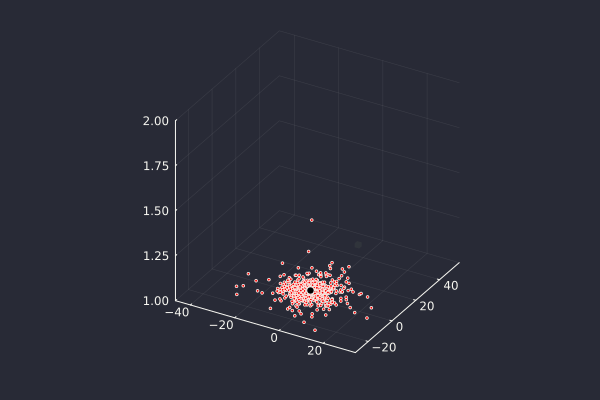

In [9]:

gif_galaxy(data,time,Target["NₛDisk"])
#gif_two_galaxies(data,time,Introoder["Nₛ"],Target["Nₛ"],[-20,30],[-30,30],[-30,20])


In [121]:
Rbulge = (-log.(rand(Target["NₛBulge"]))*Target["BulgeRadius"] .+0.1u"pc") #This (by inverse tansform sampling) gives us a negative exponential distribution on the masses. Basing myself on https://arxiv.org/pdf/1608.08350.pdf for this model
    ϕbulge = 2π *rand(Target["NₛBulge"])
    θbulge = π *rand(Target["NₛBulge"])
    vecᵣbulge = Spherical2Polar.(ustrip.(u"m",Rbulge),ϕbulge,θbulge)
reduce(vcat,transpose(vecᵣbulge))[:,3]

800-element Vector{Float64}:
  5.233494130695443e16
  1.9847941392745652e16
 -4.632601517767746e15
 -3.0479016873892868e16
 -3.1018676974573624e16
  8.454831054317338e15
 -4.93941330806037e16
 -5.194716318854956e16
 -9.143403040310576e15
 -2.328649436605159e16
  ⋮
  5.285732478628856e16
  1.0917120929884552e16
  2.011853584594016e16
 -8.562013160823582e16
  5.918735612918427e15
 -1.1496907613941775e15
  1.0285378918896384e16
 -1.1338612437737002e16
 -3.6522957378424265e15